In [18]:
"""
Poincare map for passing particles, as described in
Paul E.J., Mynick H.E., Bhattacharjee A. (2023) Journal of Plasma Physics 89(5), 905890515.
This example demonstrates unperturbed field lines.
"""

import time
from os.path import exists
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from simsopt._core.util import parallel_loop_bounds
from simsopt.field.boozermagneticfield import (
    BoozerRadialInterpolant,
    InterpolatedBoozerField,
    ShearAlfvenHarmonic
)
from simsopt.field.tracing import (
    MaxToroidalFluxStoppingCriterion,
    MinToroidalFluxStoppingCriterion,
    IterationStoppingCriterion,
    trace_particles_boozer_perturbed
)
from simsopt.util.constants import (
    ALPHA_PARTICLE_MASS as MASS,
    FUSION_ALPHA_PARTICLE_ENERGY as ENERGY,
    ALPHA_PARTICLE_CHARGE as CHARGE
)
from booz_xform import Booz_xform
from stellgap import AE3DEigenvector, saw_from_ae3d

try:
    from mpi4py import MPI
    comm = MPI.COMM_WORLD
    verbose = (comm.rank == 0)
except ImportError:
    comm = None
    mpi = None
    verbose = True

# INPUTS: ---------------------------------------------------------------------
boozmn_filename = "boozmn_precise_QH.nc"
helicity = -1 # helicity for quasisymmetry. Should be +1, -1, or 0.
mpol = 48 # poloidal resolution for booz_xform
ntor = 48 # toroidal resolution for booz_xform
order = 3 # order for field interpolation
ns_interp = 30 # number of radial grid points for field interpolation
ntheta_interp = 30 # number of poloidal grid points for field interpolation
nzeta_interp = 30 # number of toroidal grid points for field interpolation

mode = AE3DEigenvector.load_from_numpy('mode/mode_32.935kHz.npy')
Phim = 17
Phin = -17
omega = 32935.0
def sah_profile(s):
    """SAH amplitude profile"""
    s = np.asarray(s)
    sc, lw, rw, h, p, off = 0.475541, 0.068345, 0.154077, 4.124030, 1.442968, 0.026951
    result = np.zeros_like(s, dtype=float)
    result = np.where(s <= sc, 
                      h * np.exp(-((sc - s)/lw)**p), 
                      h * np.exp(-((s - sc)/rw)**p))
    amplitude = 1000.0
    return (s, amplitude*(result + off) * s * (1-s))
Phihat = sah_profile(np.linspace(0.05,0.95,30))
print(f'{Phim=}')
print(f'{Phin=}')
print(f'{omega=}')

sign_vpar = 1.0 # should be +/- 1. sign(vpar)
pitch_angle = 0.0 # = v_perp^2/(v^2 B)<0.15;

nchi_poinc = 1 # Number of zeta initial conditions guesses for poincare
ns_poinc = 20 # Number of s initial conditions guesses for poincare
Npts = 1000  # Number of poincare poits for each initial condition

tmax = 1e-2 # time limit for IVP integration
tol = 1e-8  # IVP integration tolerance

pointsize = 2.0 # marker size for Poincare plot
# END OF INPUTS ---------------------------------------------------------------

assert helicity in {-1, 0, 1}, "helicity must be -1, 0 or 1"

VELOCITY = np.sqrt(2*ENERGY/MASS)
MU = 0.5*MASS*pitch_angle*VELOCITY**2

Phim=17
Phin=-17
omega=32935.0


/tmp/ipykernel_2133229/1261757496.py:61: RuntimeWarning: invalid value encountered in power
  h * np.exp(-((sc - s)/lw)**p),
/tmp/ipykernel_2133229/1261757496.py:62: RuntimeWarning: invalid value encountered in power
  h * np.exp(-((s - sc)/rw)**p))


In [19]:
equil = Booz_xform()
equil.verbose = 0
equil.read_boozmn(boozmn_filename)
nfp = equil.nfp

time1 = time.time()
bri = BoozerRadialInterpolant(
    equil=equil,
    order=order,
    mpol=mpol,
    ntor=ntor,
    no_K=True,
    N=nfp*helicity
)
time2 = time.time()

if verbose:
    print('BRI time: ',time2-time1)

time1 = time.time()
nfp = bri.nfp
degree = 3
srange = (0, 1, ns_interp)
thetarange = (0, np.pi, ntheta_interp)
zetarange = (0, 2*np.pi/nfp, nzeta_interp)

field = InterpolatedBoozerField(
    field=bri,
    degree=degree,
    srange=srange,
    thetarange=thetarange,
    zetarange=zetarange,
    extrapolate=True,
    nfp=nfp,
    stellsym=True,
    initialize=['modB', 'modB_derivs']
)
time2 = time.time()
if verbose:
   print('Building angle interpolant took: ',time2-time1)

saw = ShearAlfvenHarmonic(
    Phihat_value_or_tuple = Phihat,
    Phim = Phim,
    Phin = Phin,
    omega = omega,
    phase = 0.0,
    B0 = field
)
omegan = omega/(Phin - Phim*helicity*nfp)

BRI time:  1.312854290008545
Building angle interpolant took:  40.75325083732605


In [20]:
def passing_map(point,tau,zeta):
    """
    Integates the gc equations from one mirror point to the next mirror point.
    point contains the [s, chi, vpar] coordinates and returns the same coordinates
    after mapping.
    """
    points = np.zeros((1,3))
    points[:,0] = point[0]
    points[:,1] = point[1] + nfp*helicity*zeta
    points[:,2] = zeta
    saw = ShearAlfvenHarmonic(
        Phihat_value_or_tuple = Phihat,
        Phim = Phim,
        Phin = Phin,
        omega = omega,
        phase = omega*tau,
        B0 = field
    )
    gc_tys, gc_zeta_hits = trace_particles_boozer_perturbed(
        perturbed_field=saw, 
        stz_inits=points, 
        parallel_speeds=[point[2]],
        mus=[MU/MASS], 
        tmax=tmax, 
        mass=MASS, 
        charge=CHARGE,
        Ekin=ENERGY,
        zetas=[zeta],
        vpars=[0],
        omegas=[omegan],
        tol=tol,
        comm=comm,
        stopping_criteria=[
            MaxToroidalFluxStoppingCriterion(1.0),
            IterationStoppingCriterion(int(4e+4))
        ],
        mode='gc_noK', 
        forget_exact_path=True,
        zetas_stop=True,
        vpars_stop=True
    )
    for i in range(len(gc_zeta_hits[0])):
        particle_not_lost = (gc_zeta_hits[0][i,1]>=0)
        if not particle_not_lost:
            print('Lost or iteration limit')
        particle_looks_passing = (np.abs(gc_zeta_hits[0][i,5])/VELOCITY>0.01)
        if (particle_not_lost and particle_looks_passing):
            point[0] = gc_zeta_hits[0][i,2]
            point[1] = gc_zeta_hits[0][i,3] - nfp*helicity*gc_zeta_hits[0][i,4]
            point[2] = gc_zeta_hits[0][i,5]
            return point, gc_zeta_hits[0][i,0]+tau, gc_zeta_hits[0][i,4]
        else:
            point[0] = -1.
            point[1] = -1.
            point[2] = -1.
            return point, -1, -1
    point[0] = -1.
    point[1] = -1.
    point[2] = -1.
    return point, -1, -1


def vpar_func(s,chi):
    """
    Compute vparallel given (s,chi) for unperturbed equilibrium.
    """
    point = np.zeros((1,3))
    point[0,0] = s
    point[0,1] = chi
    field.set_points(point)
    modB = field.modB()[0,0]
    trapped_particle = (1 - pitch_angle*modB < 0)
    if trapped_particle:
        return None
    else:
        return sign_vpar*VELOCITY*np.sqrt(1 - pitch_angle*modB)


"""
Choose one point to evaluate vpar and modB
"""
point = np.zeros((1,3))
point[:,0] = 1.0
field.set_points(point)
modB = field.modB()[0,0]
vpar = vpar_func(1,0)
G = field.G()[0,0]
iota = field.iota()[0,0]
I = field.I()[0,0]
psi = field.psi0
psip = field.psip()[0,0]
Pzeta0 = (G + nfp*helicity*I)*(MASS*vpar/modB) + CHARGE*(nfp*helicity*psi - psip)
Eprime0 = (Phin - nfp*helicity*Phim)*ENERGY - omega*Pzeta0

def vpar_func_perturbed(s,chi):
    """
    Compute vpar given (s,chi) such that Eprime = Eprime0
    Computed conserved value of shifted energy, (n - N m) E - omega Pzeta
    using specified unperturbed E, Ekin, mu.
    """
    point = np.zeros((1,4))
    point[0,0] = s
    point[0,1] = chi
    saw.set_points(point)
    modB = saw.B0.modB()[0,0]
    G = saw.B0.G()[0,0]
    iota = saw.B0.iota()[0,0]
    I = saw.B0.I()[0,0]
    psi = saw.B0.psi0*s
    psip = saw.B0.psip()[0,0]
    Phi = saw.Phi()[0,0]
    alpha = saw.alpha()[0,0]
    a = (Phin - nfp*helicity*Phim)*0.5*MASS
    b = - omega*(G + nfp*helicity*I)*MASS/modB
    c = (Phin - nfp*helicity*Phim)*(MU*modB + CHARGE*Phi) - omega*((G + nfp*helicity*I)*(CHARGE*alpha) + CHARGE*(nfp*helicity*psi - psip)) - Eprime0
    # print(alpha)
    # print(Phi)
    if ((b**2 - 4*a*c) < 0):
        return None
    else:
        # print((- b + sign_vpar*np.sqrt(b**2 - 4*a*c))/(2*a))
        return (- b + sign_vpar*np.sqrt(b**2 - 4*a*c))/(2*a)

s = np.linspace(0.1,0.9,ns_poinc)
chis = np.linspace(0,2*np.pi,nchi_poinc)
s, chis = np.meshgrid(s,chis)
s = s.flatten()
chis = chis.flatten()

"""
For each point, find value of vpar such that lambda = vperp^2/(v^2 B)
"""
first, last = parallel_loop_bounds(comm, len(s))
chis_all = []
s_all = []
vpar_all = []
for i in range(first,last):
    vpar = vpar_func_perturbed(s[i],chis[i])
    if vpar is not None:
        s_all.append(s[i])
        chis_all.append(chis[i])
        vpar_all.append(VELOCITY)

if comm is not None:
    chis = [i for o in comm.allgather(chis_all) for i in o]
    s = [i for o in comm.allgather(s_all) for i in o]
    vpar = [i for o in comm.allgather(vpar_all) for i in o]
    np.savetxt("chis_init_poinc.txt", chis)
    np.savetxt("s_init_poinc.txt", s)
    np.savetxt("vpar_init_poinc.txt", vpar)


Ntrj = len(chis)

In [21]:
print(vpar)

[12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256, 12979651.438424256]


999 iteration on 0 took 6.226040840148926s on comm.rank=0
999 iteration on 1 took 6.561031818389893s on comm.rank=0
999 iteration on 2 took 6.602444171905518s on comm.rank=0
999 iteration on 3 took 7.195763349533081s on comm.rank=0
999 iteration on 4 took 9.097371339797974s on comm.rank=0
999 iteration on 5 took 12.91268539428711s on comm.rank=0
999 iteration on 6 took 15.235121250152588s on comm.rank=0
999 iteration on 7 took 41.36616325378418s on comm.rank=0
999 iteration on 8 took 47.251803398132324s on comm.rank=0
999 iteration on 9 took 45.67462682723999s on comm.rank=0
999 iteration on 10 took 48.064270973205566s on comm.rank=0
999 iteration on 11 took 35.27755784988403s on comm.rank=0
999 iteration on 12 took 34.32755398750305s on comm.rank=0
999 iteration on 13 took 25.089423894882202s on comm.rank=0
999 iteration on 14 took 24.952069520950317s on comm.rank=0
999 iteration on 15 took 20.697046041488647s on comm.rank=0
999 iteration on 16 took 18.918898582458496s on comm.rank=0


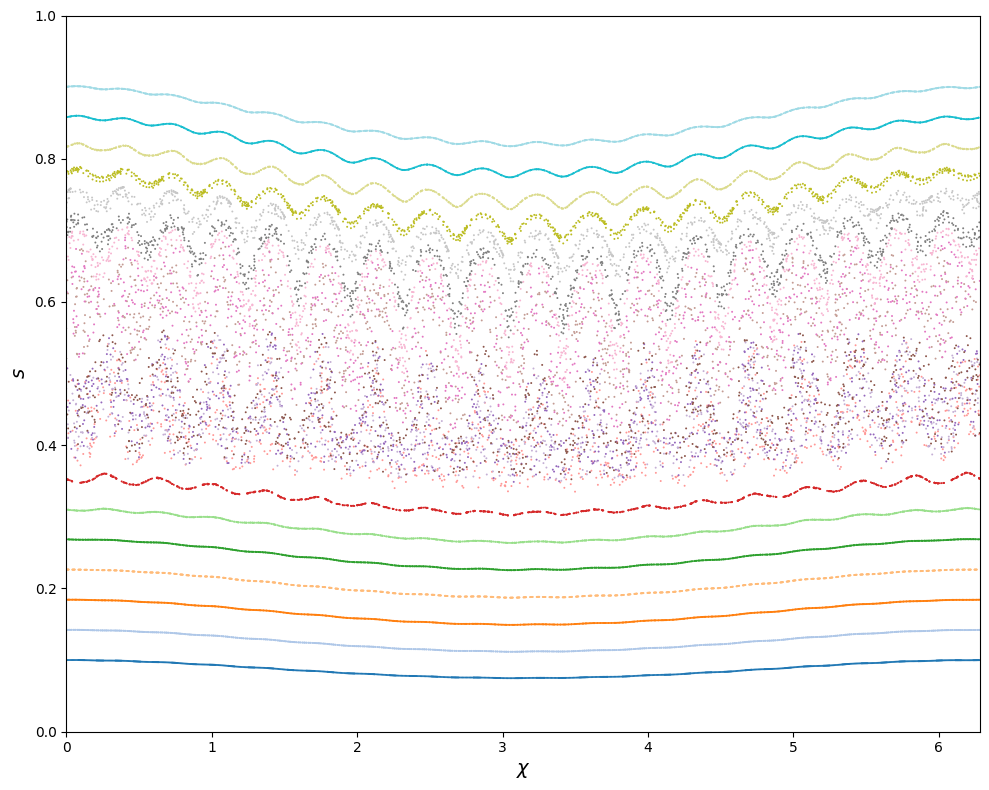

In [22]:
"""
Iterate over the Poincare initial conditions and perform the mapping.
"""
chis_all = []
s_all = []
first, last = parallel_loop_bounds(comm, Ntrj)
for itrj in range(first,last):
    time0 = time.time()
    chis_filename = 'chis_poinc_'+str(itrj)+'.txt'
    s_filename = 's_poinc_'+str(itrj)+'.txt'
    ts_filename = 'ts_poinc_'+str(itrj)+'.txt'
    vpars_filename = 'vpars_poinc_'+str(itrj)+'.txt'
    zetas_filename = 'zetas_poinc_'+str(itrj)+'.txt'
    # if (exists(chis_filename) and exists(s_filename)):
    #     chis_plot = np.loadtxt(chis_filename)
    #     vpars_plot = np.loadtxt(vpars_filename)
    #     s_plot = np.loadtxt(s_filename)
    #     if chis_plot.size < 2:
    #         chis_plot = np.array([chis_plot])
    #         vpars_plot = np.array([vpars_plot])
    #         s_plot = np.array([s_plot])
    # else:
    if True:
        tr = [s[itrj],chis[itrj],vpar[itrj]]
        chis_plot = []
        vpars_plot = []
        s_plot = []
        zetas_plot = []
        ts_plot = []
        s_plot.append(tr[0])
        chis_plot.append(tr[1])
        vpars_plot.append(tr[2])
        zetas_plot.append(0)
        ts_plot.append(0)
        tau = 0
        zet = 0
        for jj in range(Npts):
            tr,tau,zet = passing_map(tr,tau,zet)
            if tr[0] != -1:
                s_plot.append(tr[0])
                chis_plot.append(tr[1])
                vpars_plot.append(tr[2])
                zetas_plot.append(zet)
                ts_plot.append(tau)
            else:
                print('tr[0]=-1')
                break
        print(f'{jj} iteration on {itrj} took '
              +f'{time.time()-time0}s on {comm.rank=}')
        np.savetxt(chis_filename,chis_plot)
        np.savetxt(s_filename,s_plot)
        np.savetxt(vpars_filename,vpars_plot)
        np.savetxt(zetas_filename,zetas_plot)
        np.savetxt(ts_filename,ts_plot)

    chis_all.append(chis_plot)
    s_all.append(s_plot)

if comm is not None:
    chis_all = [i for o in comm.allgather(chis_all) for i in o]
    s_all = [i for o in comm.allgather(s_all) for i in o]
if verbose:
    plt.figure(1, figsize=(10, 8))
    plt.xlabel(r'$\chi$', fontsize=14)
    plt.ylabel(r'$s$', fontsize=14)
    plt.xlim([0, 2*np.pi])
    plt.ylim([0, 1])
    
    # Use a colormap to assign different colors to different particles
    cmap = mpl.colormaps['tab20']
    
    # Plot each particle trajectory with a unique color
    for i in range(len(chis_all)):
        color = cmap(i % 20)
        plt.scatter(np.mod(chis_all[i], 2*np.pi), s_all[i], 
                   marker='o', s=pointsize, color=color, 
                   edgecolors='none', label=f'Particle {i+1}')
    
    plt.tight_layout()
    plt.savefig('cpu_map_poincare_colored.pdf', dpi=300)

time2 = time.time()
if verbose:
    print('poincare time: ',time2-time1)

In [23]:
print(omegan)

645.7843137254902


In [9]:
print(np.shape(chis_all))

(20, 1001)


In [10]:
print(s_all[0])

[0.1        0.08787644 0.07496376 ... 0.0823862  0.09869794 0.09351813]


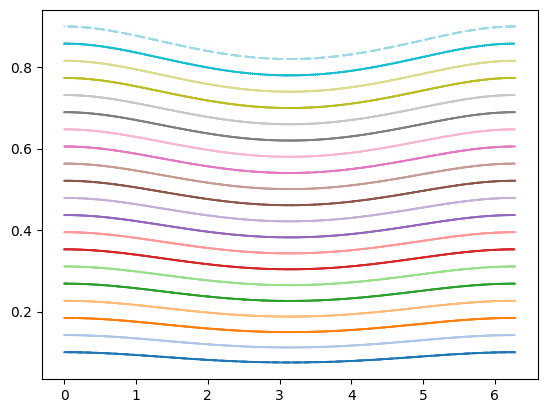

In [11]:
for i in range(len(chis_all)):
    color = cmap(i % 20)
    plt.scatter(np.mod(chis_all[i], 2*np.pi), s_all[i], 
               marker='o', s=pointsize, color=color, 
               edgecolors='none', label=f'Particle {i+1}')
    